In [24]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [25]:
cin = pd.read_csv('https://raw.githubusercontent.com/data-to-insight/D2I-Jupyter-Notebook-Tools/refs/heads/main/ml-data%20science%20tutorials/data/CINdetails.csv')
characteristics = pd.read_csv('https://raw.githubusercontent.com/data-to-insight/D2I-Jupyter-Notebook-Tools/refs/heads/main/ml-data%20science%20tutorials/data/ChildCharacteristics.csv')
identifiers = pd.read_csv('https://raw.githubusercontent.com/data-to-insight/D2I-Jupyter-Notebook-Tools/refs/heads/main/ml-data%20science%20tutorials/data/ChildIdentifiers.csv')

identifiers


,Unnamed: 0,LAchildID,UPN,FormerUPN,UPNunknown,PersonBirthDate,ExpectedPersonBirthDate,GenderCurrent,PersonDeathDate
0,0,RND000215205141,A850728973744,NaN,NaN,2019-12-06,NaN,1,NaN
1,1,RND000824303014,A141396438491,NaN,NaN,2011-04-27,NaN,9,NaN
2,2,RND000750143123,A929946861554,NaN,NaN,2017-06-06,NaN,1,NaN
3,3,RND000909164501,A612330267292,NaN,NaN,2014-10-03,NaN,0,NaN
4,4,RND000382171815,A604459366806,NaN,NaN,2019-09-25,NaN,2,NaN
...,...,...,...,...,...,...,...,...,...
327,327,RND000112711501,A465246916125,NaN,NaN,2010-07-07,NaN,2,NaN
328,328,RND000513120794,A540014111973,NaN,NaN,2018-08-14,NaN,2,NaN
329,329,RND000541643134,A549582689058,NaN,NaN,2021-12-09,NaN,1,NaN
330,330,RND000404939452,A889492349196,NaN,NaN,2013-07-23,NaN,2,NaN


In [26]:
# Keep only the most recent plan
cin.sort_values('CINreferralDate', inplace=True, ascending=False)
cin.drop_duplicates('LAchildID', inplace=True, keep='first')

cin['CINplan'] = 1

In [27]:
df = characteristics.merge(identifiers, how='left', on='LAchildID')
df = df.merge(cin, how='left', on='LAchildID')

df['CINplan'] = df['CINplan'].fillna(0)

cols_to_keep = ['Ethnicity', 'PersonBirthDate', 'GenderCurrent', 'CINplan']

df = df[cols_to_keep]

df['Age'] = pd.to_datetime('today') - pd.to_datetime(df['PersonBirthDate'])

df['Age'] = df['Age']

df.drop(columns=['PersonBirthDate'], inplace=True)

df['Age'] = df['Age']/pd.Timedelta(days=365)

In [28]:
def ethnicity_check(row):
    if row[0] == 'W':
        return 'white'
    if (row[0] == 'A' ) | (row[0] == 'C' ):
        return 'asian'
    if row[0] == 'M':
        return 'mixed'
    if row[0] == 'B':
        return 'black'
    else:
        return 'unknown'
    
df['Ethnicity'] = df['Ethnicity'].apply(ethnicity_check)
df['GenderCurrent'] = df['GenderCurrent'].map({1:'male',
                                               2:'female',
                                               0:'other',
                                               9:'other'})

In [29]:
df_encoded = pd.get_dummies(df[['GenderCurrent', 'Ethnicity']])
cp = df[['CINplan', 'Age']]
full_encoded_df = cp.merge(df_encoded, how='left', left_index=True, right_index=True)
full_encoded_df

,CINplan,Age,GenderCurrent_female,GenderCurrent_male,GenderCurrent_other,Ethnicity_asian,Ethnicity_black,Ethnicity_mixed,Ethnicity_unknown,Ethnicity_white
0,1.0,4.831054,False,True,False,False,False,False,False,True
1,1.0,13.447492,False,False,True,False,False,False,False,True
2,1.0,7.332424,False,True,False,True,False,False,False,False
3,1.0,10.009136,False,False,True,False,False,True,False,False
4,1.0,5.028314,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
327,0.0,14.252972,True,False,False,False,False,False,False,True
328,0.0,6.143383,True,False,False,False,False,False,False,True
329,0.0,2.820095,False,True,False,False,True,False,False,False
330,0.0,11.206397,True,False,False,True,False,False,False,False


In [30]:
# Split data to train/test split
X = full_encoded_df.drop('CINplan', axis=1) # Independent
y = full_encoded_df['CINplan'] # Dependent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7164179104477612


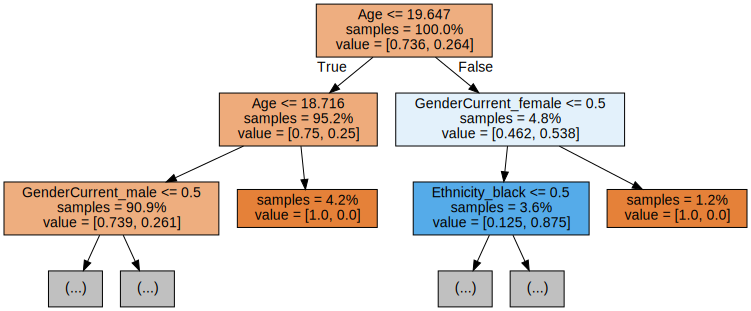

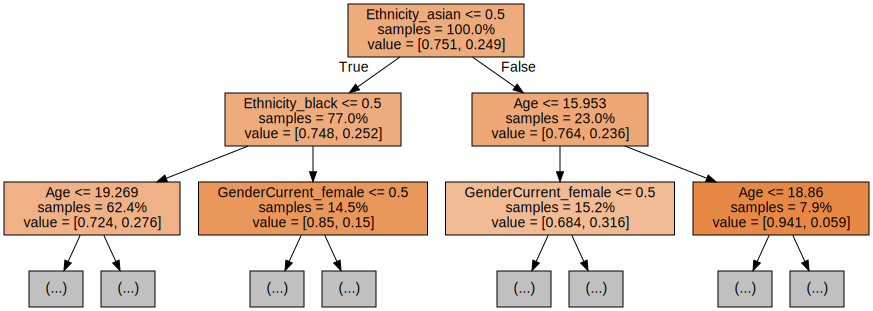

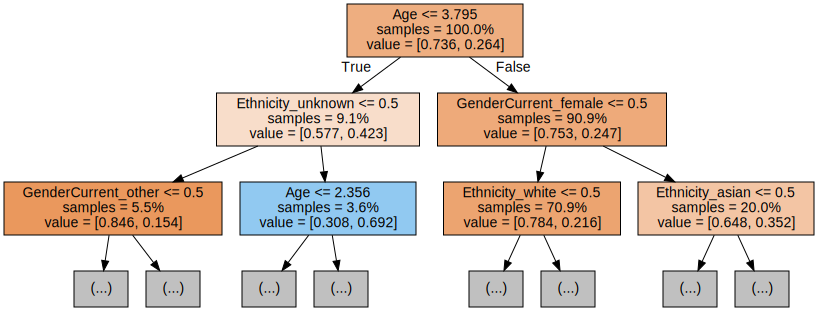

In [32]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

The trees all show the first few nodes to keep them simple. The darker the colour the more of one outcome in each node. The nodes have information about which variable is used for the splitting, the percent of total samples in the split, and the percent split between classes in the split.

We can now move to tuning our hyperparameters. If we use SKlearn's RandomisedSearchCV, it performs a randomized search on hyper parameters within a set range of parameters.

Estimators are the number of trees in the forest, more trees improves accuracy, but increases computational cost. Max depth is how deep each tree in the forest goes with node splits, too many will overfit, too few will underfit.

RandomizedSearchCV makes lots of models and returns a variable for the best one, which includes information about the hyperparameters.

In [33]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73b47bf95bd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73b479cc60b0>})

In [34]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 6, 'n_estimators': 396}


AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

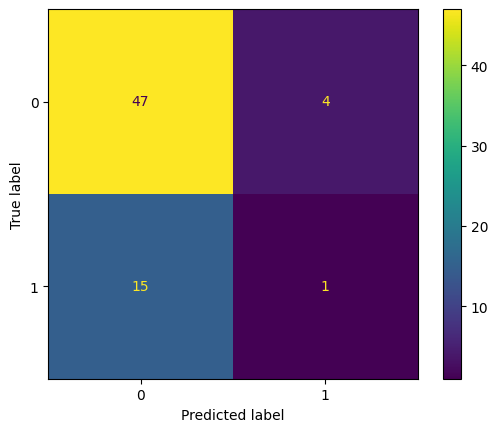

In [35]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

KNN assumes that, things similar to eachother will have similar outcomes. Imagine we are trying to predict shoe size form a bunch of different human dimensions, using knn we might determine that people with similar height and hand size also have a similar shoe size. We can use this for categorization by giving a range of hand/height sizes that form categories, then, when we have a new data point, if it fits in a category, we can make a shoe size prediction. We determine which category a data point fits in by finding the category which has the most points close to it. (demo on paint)

In [36]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6119402985074627
Precision: 0.08333333333333333
Recall: 0.0625


<Axes: >

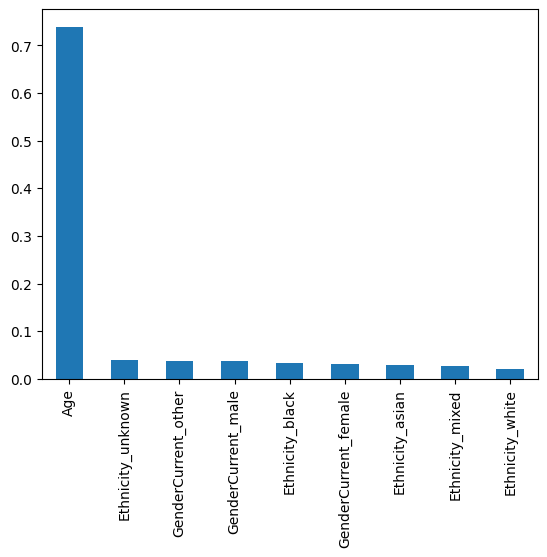

In [37]:

# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()